# 12-752: Data-Driven Building Energy Management
## Fall 2016, Carnegie Mellon University

## Assignment \#2

We will begin by unpickling the dataset we had played around with in Lecture 4. But first, we will load most modules we will be using:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import itertools
import pickle

%matplotlib inline

To unpickle just do this:

In [3]:
pickle_file = open('../../F16-12-752/lectures/data/campusDemand.pkl','rb')
pickled_data = pickle.load(pickle_file)
pickle_file.close()

# Since we pickled them all together as a list, I'm going to assign each element of the list to the same variable
# we had been using before:
data = pickled_data[0]
pointNames = pickled_data[1]
data_by_day = pickled_data[2]
idx = pickled_data[3]

## -=-=-= Exploring hourly and weekly consumption patterns (no seasonality) =-=-=-

# Task \#1 (10%)

Create a new Pandas Data Frame that contains only two columns (Time and Value) and only the rows that belong to the University-wide meter (Electric kW Calculations Main Campus). In other words, get rid of the Point Name column and select only the rows for the campus meter.

In [4]:
meter = 'Electric kW Calculations - Main Campus kW'
nw_data = data.loc[data['Point name']==meter,['Time','Value']]
nw_data.head()

,Time,Value
152348,2013-11-10 00:00:30,8367.816250
152349,2013-11-10 00:01:30,8287.111375
152350,2013-11-10 00:02:30,8340.608125
152351,2013-11-10 00:03:30,8342.061625
152352,2013-11-10 00:04:30,8341.360375


# Task \#2 (10%)

In one figure, plot one histogram showing the average hourly consumption on the entire dataset.
In a separate figure, plot 7 subplots with similar histograms but now showing the average hourly consumption for each day of the weeek (hence the 7 supplots).

Monday , Kurtosis:  [ 3.04913895]
Tuesday , Kurtosis:  [ 1.8055023]
Wednesday , Kurtosis:  [ 2.56509818]
Thursday , Kurtosis:  [ 3.7183961]
Friday , Kurtosis:  [ 3.77420728]
Saturday , Kurtosis:  [ 4.96616692]
Sunday , Kurtosis:  [ 4.57276101]


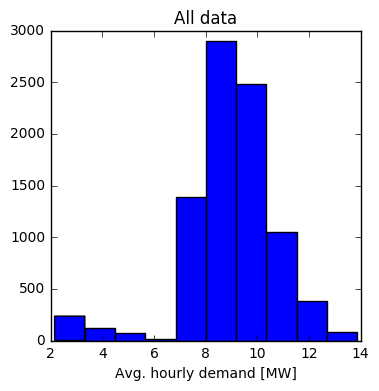

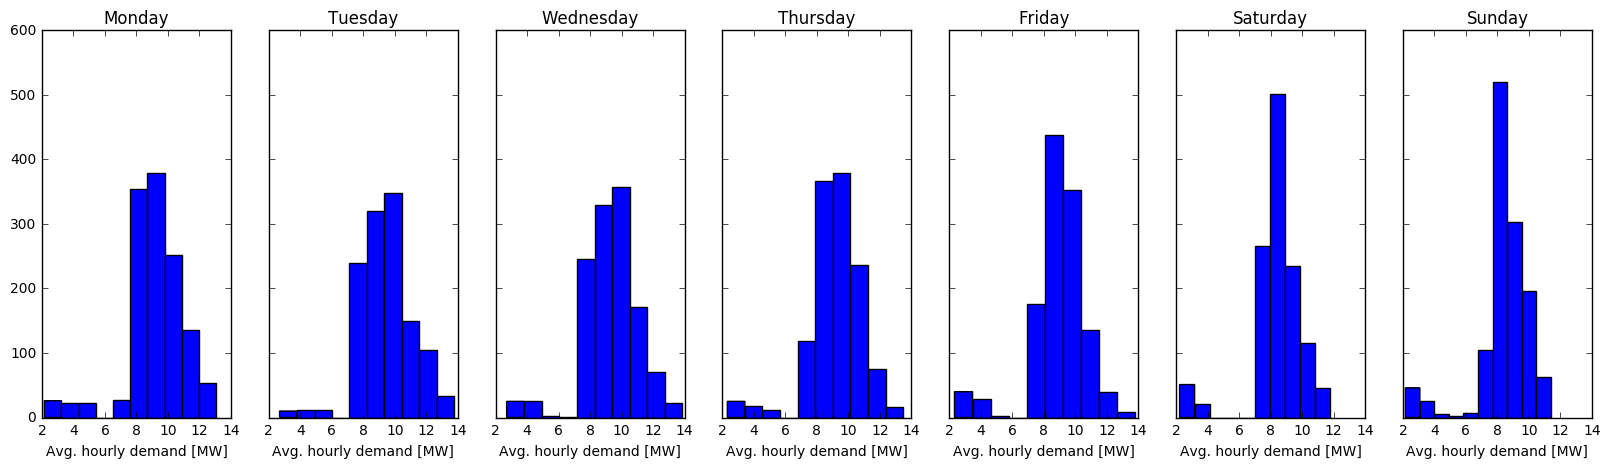

In [4]:
from scipy import stats as st
fig = plt.figure(figsize=(4,4))
x = nw_data.groupby([nw_data['Time'].dt.date,nw_data['Time'].dt.hour]).mean()/1000
plt.hist(x.values)
plt.title('All data')
plt.xlabel('Avg. hourly demand [MW]')

fig,ax = plt.subplots(1,7,figsize=(20,5),sharey='row',sharex='row')
Days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
nw_data_day = []
for d,df in enumerate(data_by_day):
    df = df.loc[df['Point name']==meter,['Time','Value']]
    x = df.groupby([df['Time'].dt.date,df['Time'].dt.hour]).mean()/1000
    nw_data_day.append(df)
    ax[d].hist(x.values)
    print(Days[d], ', Kurtosis: ', st.kurtosis(x.values))
    ax[d].set_title(Days[d])
    ax[d].set_xlabel('Avg. hourly demand [MW]')
    pass
plt.show()

# Task \#3 (10%)

In one figure, create a box plot of the average hourly electricity consumption for each hour of the day (i.e., your plot will show 24 *boxes*, one for each hour of the day, and each *box* will represent the distribution of the average hourly consumption in the dataset for that hour).

In another figure, create 7 subplots showing the same box plots as above, but now for each of the seven days of the week.

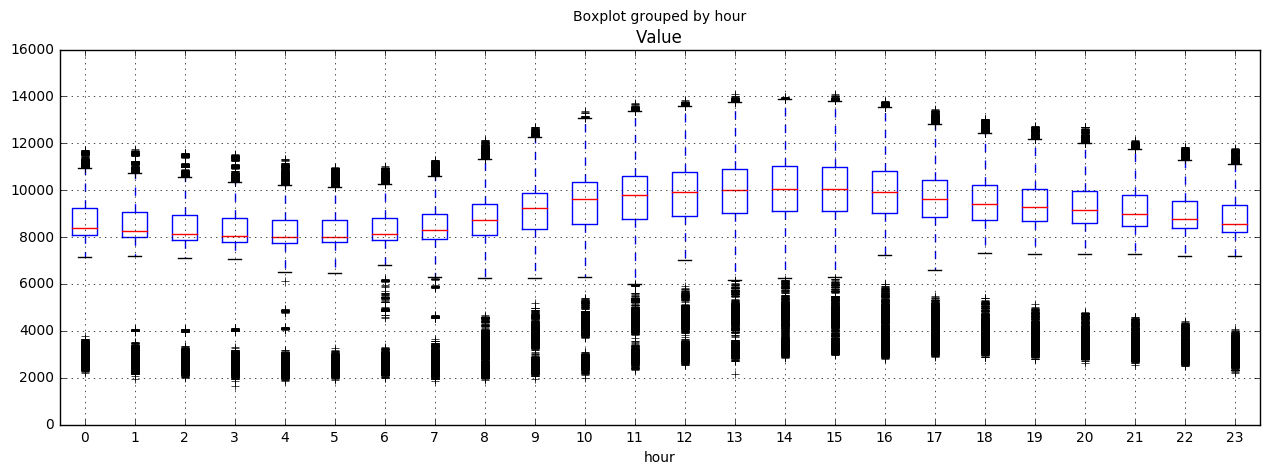

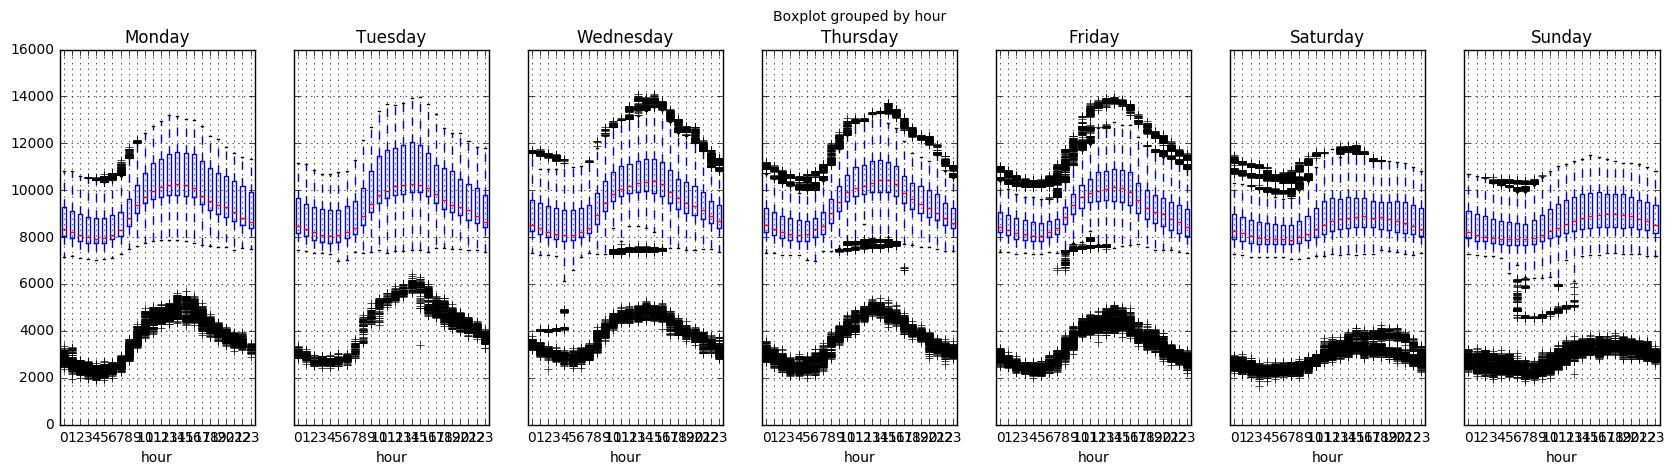

In [5]:
# Fig 1
nw_data['hour'] = nw_data['Time'].dt.hour
nw_data.boxplot(column='Value',by='hour',figsize=(15,5));
# Fig 2
fig,ax = plt.subplots(1,7,figsize=(20,5),sharey='row',sharex='row')
for d,df in enumerate(nw_data_day):
    temp = df
    temp['hour'] = temp['Time'].dt.hour
    temp.boxplot(column='Value',by='hour',ax=ax[d]);
    ax[d].set_title(Days[d])
    pass
nw_data.drop(['hour'],axis=1,inplace=True)
plt.show()

## -=-=-= Exploring seasonal effects =-=-=-

# Task \#4 (10%)

Create a **stem plot** of the average daily electricity consumption for the whole dataset (i.e., the plot should have ~365 stems):

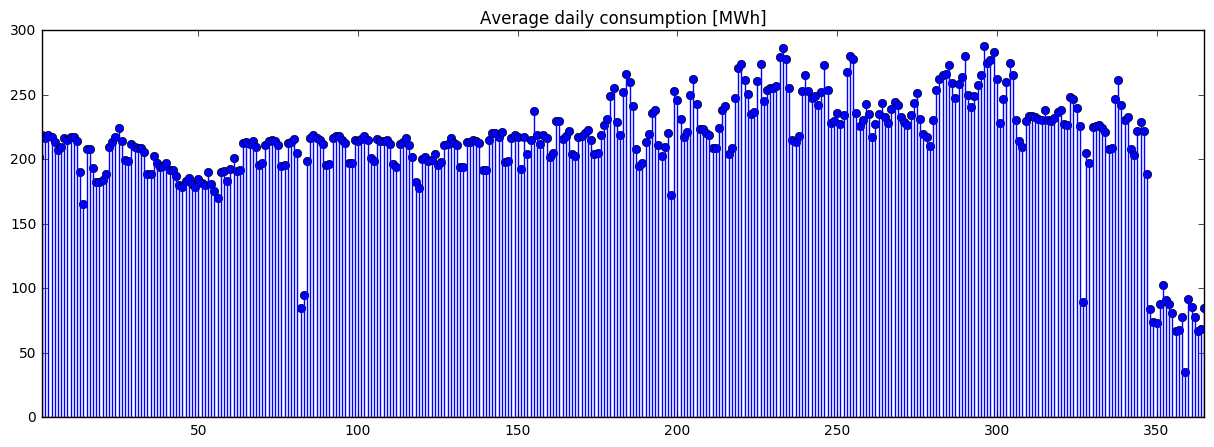

In [6]:
x = (nw_data.groupby([nw_data['Time'].dt.date]).sum()/60000).reset_index()
#df['Time'] = df['Time'].apply(pd.to_datetime)
#x = df.groupby([df['Time'].dt.month,df['Time'].dt.day]).mean()
fig = plt.figure(figsize=(15,5))
plt.stem(np.arange(len(x)),x['Value']); plt.xlim([1,365])
plt.title('Average daily consumption [MWh]');

# Task #5 (10%)

What are your findings so far? Please elaborate on how the above plots and analysis have informed you about the data. 


During the period from Nov. 10, 2013 until Nov. 10, 2014, the following conclusions can be drawn regarding the electricity consumption campus-wide:
- Average power demand was around 8-10 MW, whereas average daily energy consumption was about 215 MWh. 
- During weekdays, power consumption raised up to 14 MW. Furthermore, the histograms of hourly power demand show that consumption is noticeable more spread during weekdays than during weekends. This behavior translates into a higher kurtosis in weekend data compered to weekdays.
- On average, daily peak periods took place between 1 pm - 4 pm.
- Wednesdays to Fridays are the days with the highest electricity consumption.
- The stem plot suggests that lowest daily energy consumption happened during late October and early November 2014. According to this graph, electricity consumption on-campus slashed by a factor of 2.5x throughout those days (~60 MWh-day). Although this is what the data shows, this low power consumption prolonged for several days, which is a little suspicious considering that data of Nov. 2013 doesn't render a similar behavior. Getting into the details, we find that there are missing values for a number of hours on those days as well as on Jan. 31, Feb. 1 and Oct. 3 2014. These missing values translate into a remarkably ebbed daily consumption.
- Apart from that, the stem plot also shows that average daily electricity before May was around 200 MWh. As summer kicked in, the consumption not only became more volatile but also the average raised to 240 MWh/day with some spikes over 280 MWh/day.

# Task \#6 (10%)

Create a new DataFrame called ```loadCurves```, which contains 24 columns (one for each hour of the day) and each of those columns has a Series with as many rows as there are days in our dataset. Each column wil be composed of the average power consumed during that particular hour for each day of the year.

Note: You may benefit from knowing about the ```groupby``` and ```unstack``` methods for DataFrames.

In [7]:
loadCurves = nw_data.groupby([nw_data['Time'].dt.date,nw_data['Time'].dt.hour]).mean().unstack(level=-1).reset_index()
loadCurves['Time'] = loadCurves['Time'].apply(pd.to_datetime)
# Nan values are replaced with the average of the corresponding hour
for h in range(24):
     loadCurves.iloc[loadCurves.index[loadCurves['Value'][h].isnull()],h+1] = np.mean(loadCurves['Value'][h])
loadCurves.tail()

Time        Value                                         \
Time                       0            1            2            3   
361  2014-11-06  2905.003117  2683.539200  2495.221756  2348.223848   
362  2014-11-07  2935.847904  2648.282981  2511.383092  2384.981381   
363  2014-11-08  2549.611604  2379.817840  2460.801617  2323.210263   
364  2014-11-09  2663.987521  2736.404758  2994.988894  2872.978442   
365  2014-11-10  2802.089725  2618.999035  2495.330723  2477.285796   

                                                                       \
Time            4            5            6            7            8   
361   2311.094233  2337.088448  2384.543623  2648.244044  3304.974773   
362   2382.607677  2331.036554  2475.493075  2627.904006  3084.020852   
363   2285.100427  2351.840900  2332.130817  2364.017463  2418.714773   
364   2783.141771  2808.144873  2373.348556  2153.986987  2203.646306   
365   2384.273306  2424.666860  2442.839906  2580.533002  3242.791515   

         ...                                                           \
Time     ...                14           15           16           17   
361      ...       5015.386325  4575.369704  4567.877573  4321.436002   
362      ...       4156.215688  4288.409146  4030.830617  3730.555610   
363      ...       3198.565281  3316.330808  3302.226796  3229.108919   
364      ...       3170.591587  3221.950050  3111.021467  3257.593969   
365      ...       4947.976231  5009.875792  4874.107165  4685.694296   

                                                                       \
Time           18           19           20           21           22   
361   4016.435369  3825.593042  3667.274340  3442.750644  3301.163371   
362   3510.038383  3355.897715  3113.278737  2881.147677  2784.916377   
363   3233.443767  3086.238987  3065.329917  2850.278075  2802.384017   
364   3317.927902  3104.811938  3140.474817  3030.308079  3031.118046   
365   4252.196563  3959.348133  3832.897792  3703.072237  3569.803215   

                   
Time           23  
361   3102.265700  
362   2596.009454  
363   2704.341360  
364   2891.945333  
365   8615.376134  

[5 rows x 25 columns]

# Task \#7 (10%)
Create a heatmap of the daily load curves for campus, similar to those shown in Paper \#1. In particular, this heatmap will be a 2D map with the horizontal axis showing the hours of the day (24 in total), and the vertical axis showing the day of the year (~365 total). Then each cell will be color-coded with the value corresponding to the average power consumed during this hour. 

Try different colormaps to see which one works best for you.

Note: you may need to normalize the data to see differences.

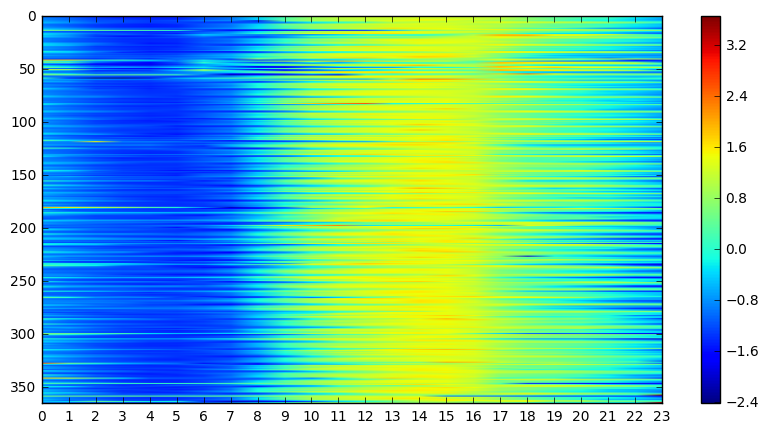

In [93]:
loadCurves_mat = loadCurves.iloc[:,1:].as_matrix()
# Normilizing by rows
means = np.nanmean(loadCurves_mat,axis=1)[:,None]
stds = np.nanstd(loadCurves_mat,axis=1)[:,None]
loadCurves_r = (loadCurves_mat - means) / stds
# Normilizing by columns
loadCurves_c = (loadCurves_mat - np.nanmean(loadCurves_mat,axis=0)) / np.nanstd(loadCurves_mat,axis=0)

fig = plt.figure(figsize=(10,5))
plt.imshow(loadCurves_r,aspect='auto')
plt.xlim([0,23]);plt.xticks(range(0,24,1)); plt.colorbar();

# Task \#8 (20%)

Let's see if we can find some patterns in these load curves. Using your favorite implementation and flavor of the k-means algorithm, play around with clustering the daily loadCurves to see if we can find 2 or 3 clusters that would best differentiate between weekdays and weekends. In other words, perform k-means (or k-medioids, or whatever) on the dataset with $k \in \{2, 3\}$ and the dataset being 365 samples of 24-dimensional vectors.

Note: you will only check the weekend vs. weekday labels **after** clustering (i.e., do not use this attribute for clustering, but rather only the 24 average hourly consumption values).

In [94]:
# I am creating a k-means function to find k centers on the dataset X with k random vectors given as intial values
def KMeans(X, centers, niters=100):
    for _ in range(niters):
        # Assign a cluster to every row of X
        dist = (-2*X.dot(centers.T) + np.sum(X**2,axis=1)[:,None] + np.sum(centers**2, axis=1))
        Cl = np.eye(centers.shape[0])[np.argmin(dist,axis=1),:]

        # Compute the means
        centers = Cl.T.dot(X)/np.sum(Cl,axis=0)[:,None]

    dist = (-2*X.dot(centers.T) + np.sum(X**2,axis=1)[:,None] + np.sum(centers**2, axis=1))
    closest = np.argmin(dist,axis=0)
    return centers,Cl,closest,dist

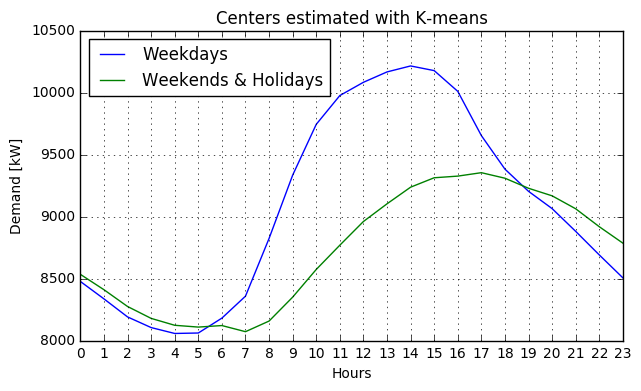

In [96]:
k = 2; X = loadCurves_r
P = np.random.permutation(X.shape[0])
mus, cl, closest, dist = KMeans(X,X[P[:k],:])

# Denormalization of centers
centers = mus*stds[closest] + means[closest]

fig = plt.figure(figsize=(7,4))
if np.argmin(cl[0]) != 0:
    cl = cl[:,[1,0]]
    centers = centers[[1,0],:]
    
labels = ['Weekdays','Weekends & Holidays']
plt.plot(np.arange(0,24),centers.T); plt.legend(labels,loc=2);plt.xlim([0,23]);plt.xticks(range(0,24,1))
plt.xlabel('Hours');plt.ylabel('Demand [kW]'); plt.grid(); plt.title('Centers estimated with K-means');

# Task \#9 (10%)

In separate plots (one for each cluster), plot the cluster centroids (in a dark, thick line) and the load curves that belong to the cluster (using thin grayish lines), just like the paper did. 

What did you learn from the experiment above?

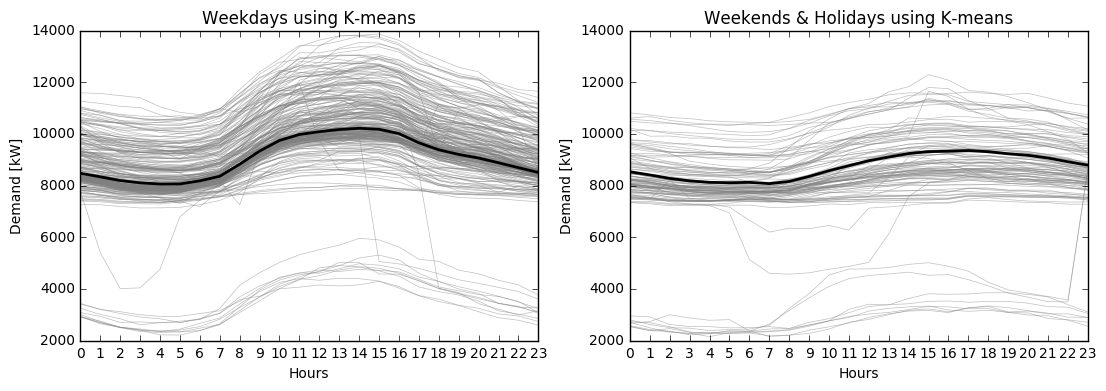

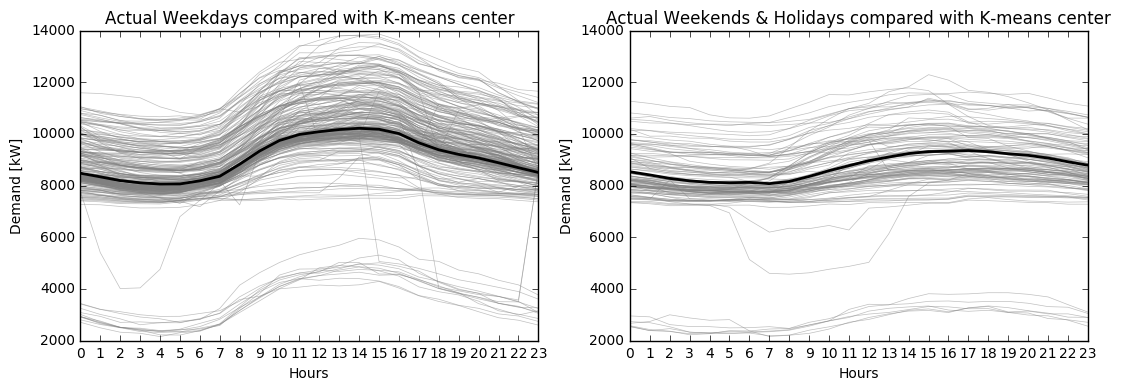

In [97]:
fig,ax = plt.subplots(1,centers.shape[0],figsize=(13,4))#,sharey='row',sharex='row')
for i,y in enumerate(centers):
    idx = np.where(cl[:,i] == 1)
    ax[i].plot(np.arange(0,24),loadCurves_mat[idx].T,color='gray',alpha=0.5, linewidth=0.5)
    ax[i].plot(np.arange(0,24),y,color='black',linewidth=2)
    
    ax[i].set_xlim([0,23]);ax[i].set_ylim([2000,14000]);ax[i].set_xticks(range(0,24,1))
    ax[i].set_xlabel('Hours');ax[i].set_ylabel('Demand [kW]'); ax[i].set_title(labels[i]+' using K-means');
    pass

# Actual weekday, weekends (including holidays) in the dataset 
wks = np.array([1 if i > 4  else 0 for i in loadCurves['Time'].dt.weekday])
holidays = np.reshape(np.array([2013,11,11,2013,11,28,2013,12,25,2014,1,1,
          2014,1,20,2014,2,17,2014,4,20,2014,5,26,2014,7,4,2014,9,1,2014,10,13]),(-1,3))
wks[loadCurves[loadCurves['Time'].isin([dt.datetime(i[0],i[1],i[2]) for i in holidays])].index] = 1

fig,ax = plt.subplots(1,centers.shape[0],figsize=(13,4))
for i,y in enumerate(centers):
    idx = np.where(wks == i)
    ax[i].plot(np.arange(0,24),loadCurves_mat[idx].T,color='gray',alpha=0.5, linewidth=0.5)
    ax[i].plot(np.arange(0,24),y,color='black',linewidth=2)
    
    ax[i].set_xlim([0,23]);ax[i].set_ylim([2000,14000]);ax[i].set_xticks(range(0,24,1));ax[i].set_xlabel('Hours');
    ax[i].set_ylabel('Demand [kW]'); ax[i].set_title('Actual '+labels[i]+' compared with K-means center');
    pass
plt.show();

In [88]:
# Accuracy of k-means classifier
wks_hat = np.maximum(cl[:,1] - cl[:,0],0)
print('K-means classifier accuracy: {0:.4}%'.format((wks_hat==wks).mean()*100))

K-means classifier accuracy: 94.54%


### Takeaways
- The K-means algorithm is a powerful approach to identify weekdays and weekends from this dataset in an unsupervised fashion. A 94.54% of classification accuracy was accomplished using this method.
- Since the aim is to characterize the hourly load profile during a day in order to classify weekdays and weekends, the normalization of matrix X (365x24) should be over the rows rather than columns to capture the desired behavior. Otherwise, doing the normalization across columns yields a complete different classifier that performs very poorly. The underlying reason is that normalizing over the columns captures the variation of power consumption throughout the year for each hour; therefore, such variation doesn't necessarily encode the information to discern weekdays from weekends and holydays.
- The hourly missing values during late October and early November 2014 are clearly influencing the estimations. The grey lines at the bottom of the above subplot correspond to the load profile of those days. To better analyze the electricity consumption on-campus through a full year, a larger dataset will be needed, and data from those days should be deemed as anomalies and stripped from the dataset.
- The load profile during weekends is shifted with respect to weekdays. The peak period happens in the evening (around 4-6 pm), whereas during the week the peak consumptions happens in the afternoon between 1-3 pm. Moreover, the average peak demand on weekends is ~9,300 MW and ~10,200 MW on weekdays.